In [1]:
import os
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset

import numpy as np 
import pickle
import matplotlib.pyplot as plt
import time
import copy

from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/gnn')

# Load data and normalize

In [2]:
X = pickle.load(open('../dataset/train/cross_subject_data_0.pickle', 'rb'))
y = X['train_y']

X = X['train_x'].astype(np.float32)

label_map = {'imagine_both_feet': 0, 'imagine_both_fist': 1, 'imagine_left_fist': 2, 'imagine_right_fist': 3}
y = np.vectorize(label_map.__getitem__)(y)

In [3]:
# Normalize
mean, std = X.mean(), X.std()
X = (X - mean) / std

# Import Adj Matrix

In [4]:
from convert_to_graphs import n_graph, d_graph, s_graph, normalize_adj

seq_len = 100
n_channels = 64
batch_size = 32

A = n_graph()
A = np.array(A, dtype=np.float32)
A = normalize_adj(A)
A = A + np.eye(A.shape[0], dtype=np.float32)


A_big = np.zeros((n_channels*batch_size, n_channels*batch_size), dtype=np.float32)
print(A_big.shape)
for i in range(0, A_big.shape[0], n_channels):
    A_big[i:i+n_channels, i:i+n_channels] = A

# A_bigger = []
# for i in range(batch_size):
#     A_bigger.append(A_big)

# A_bigger = np.array(A_bigger, dtype=np.float32)

A = torch.Tensor(A_big).to(device)

print('Adjacency Matrix A:')
print(A.shape)



(2048, 2048)
Adjacency Matrix A:
torch.Size([2048, 2048])


In [5]:
# import mne 
# import pandas as pd
# import numpy as np 

# ten_twenty_montage = mne.channels.make_standard_montage("standard_1020")
# ch_names = pd.read_csv("../dataset/physionet.org_csv/S001/S001R01.csv")
# ch_names = ch_names.columns[2:]

# ch_pos_1020 = ten_twenty_montage.get_positions()["ch_pos"]

# ch_pos_1010 = {}
# for ch_name_orig in ch_names:
#     ch_name = ch_name_orig.upper().rstrip(".")
#     if "Z" in ch_name:
#         ch_name = ch_name.replace("Z", "z")
#     if "P" in ch_name and len(ch_name) > 2:
#         ch_name = ch_name.replace("P", "p")
#     if "Cp" in ch_name:
#         ch_name = ch_name.replace("Cp", "CP")
#     if "Tp" in ch_name:
#         ch_name = ch_name.replace("Tp", "TP")
#     if "pO" in ch_name:
#         ch_name = ch_name.replace("pO", "PO")
#     ch_pos_1010[ch_name_orig] = ch_pos_1020[ch_name]
# print(len(ch_pos_1010))

# ch_pos_1010_names = []
# ch_pos_1010_dist = []
# for name, value in ch_pos_1010.items():
#     ch_pos_1010_names.append(name)
#     ch_pos_1010_dist.append(value)
# ch_pos_1010_dist = np.array(ch_pos_1010_dist)

# A = d_graph(n_channels, ch_pos_1010_dist)
# A = np.array(A, dtype=np.float32)

# A = normalize_adj(A)
# A = A + np.eye(A.shape[0], dtype=np.float32)


# A_big = np.zeros((n_channels*batch_size, n_channels*batch_size), dtype=np.float32)
# print(A_big.shape)
# for i in range(0, A_big.shape[0], n_channels):
#     A_big[i:i+n_channels, i:i+n_channels] = A

# # A_bigger = []
# # for i in range(batch_size):
# #     A_bigger.append(A_big)

# # A_bigger = np.array(A_bigger, dtype=np.float32)

# A = torch.Tensor(A_big).to(device)

# print('Adjacency Matrix A:')
# print(A.shape)

# Convert data to [n_samples, n_channels] -> [n_samples, seq_len, n_channels]

In [6]:
# def reshape_data_gnn(X, y, seq_len):
#     print('X original shape:', X.shape)
#     print('y original shape:', y.shape)
#     print('Seq len:', seq_len)
#     len_tail = X.shape[0] % seq_len
#     if len_tail == 0:
#         X = X.reshape(-1, seq_len*n_channels, 1)
#         y = y.reshape(-1, seq_len)
#     else:
#         X = X[:-len_tail].reshape(-1, seq_len*n_channels, 1)
#         y = y[:-len_tail].reshape(-1, seq_len)
#     y = y[:, -1]
#     print('X conversion shape:', X.shape)
#     print('y conversion shape:', y.shape)
#     return X, y

def reshape_data_gnn_2(X, y, seq_len):
    print('X original shape:', X.shape)
    print('y original shape:', y.shape)
    print('Seq len:', seq_len)
    len_tail = X.shape[0] % seq_len
    if len_tail == 0:
        X = X.reshape(-1, seq_len, n_channels)
        X = np.moveaxis(X, 1, -1)
        y = y.reshape(-1, seq_len)
    else:
        X = X[:-len_tail].reshape(-1, seq_len, n_channels)
        X = np.moveaxis(X, 1, -1)
        y = y[:-len_tail].reshape(-1, seq_len)
    y = y[:, -1]
    print('X conversion shape:', X.shape)
    print('y conversion shape:', y.shape)
    return X, y

X, y = reshape_data_gnn_2(X, y, seq_len)

X original shape: (5606636, 64)
y original shape: (5606636,)
Seq len: 100
X conversion shape: (56066, 64, 100)
y conversion shape: (56066,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)
def print_class_dist(y):
    dist = {}

    labels = np.unique(y)
    for label in labels:
        dist[str(label)] = len(y[y == label]) / len(y)
    print(dist)
print_class_dist(y)
print_class_dist(y_train)
print_class_dist(y_test)

{'0': 0.25000891806085684, '1': 0.250115934791139, '2': 0.25175685798879893, '3': 0.24811828915920522}
{'0': 0.25, '1': 0.2501114777490413, '2': 0.25176134843485243, '3': 0.2481271738161063}
{'0': 0.2500445871232388, '1': 0.25013376136971643, '2': 0.25173889780631353, '3': 0.24808275370073124}


In [8]:
X_train, y_train = torch.tensor(X_train).to(device), torch.tensor(y_train).to(device)
X_test, y_test = torch.tensor(X_test).to(device), torch.tensor(y_test).to(device)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}
dataloaders = {'train': train_loader, 'val': test_loader}
class_names = list(label_map.keys())
print(class_names)

['imagine_both_feet', 'imagine_both_fist', 'imagine_left_fist', 'imagine_right_fist']


In [9]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            writer.add_scalar(f'{phase} loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase} accuracy', epoch_acc, epoch)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

# Test computation

In [10]:
# import time
# import torch
# from layers_original import GraphConvolution

# torch.manual_seed(0)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# x = torch.randn(16, 64, 32).to(device)
# x = x.view(-1, 32)
# # A = torch.randn(16*64, 16*64).to(device)
# # weight = torch.randn(32, 512).to(device)
# # A = A.to_sparse()
# print(A.is_sparse)
# gcn = GraphConvolution(32, 128).to(device)
# now = time.time()

# out = gcn(x, A)
# print(out.shape)
# out = out.view(16, 64, 128)
# # support = torch.matmul(x, weight)
# # output = torch.bmm(A, support)
# print(out.shape)
# print('elapsed time:', time.time() - now)

In [11]:
in_features = seq_len
hidden_size_1 = 512
hidden_size_2 = 512
hidden_size_3 = 512
hidden_size_4 = 4
num_classes = 4
num_epochs = 300

# from layers_batchwise import BatchwiseGraphConvolution
from layers_batchwise_2 import GraphConvolution
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, in_features, hidden_size_1, hidden_size_2, n_nodes, embed_dim, num_classes):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(in_features, hidden_size_1, batch_size, n_channels)
        self.gc2 = GraphConvolution(hidden_size_1, hidden_size_2, batch_size, n_channels)
        self.gc3 = GraphConvolution(hidden_size_2, hidden_size_3, batch_size, n_channels)
        self.gc4 = GraphConvolution(hidden_size_3, hidden_size_4, batch_size, n_channels)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(hidden_size_4*n_channels, num_classes)
        self.node_embeddings = nn.Parameter(torch.randn(n_nodes*batch_size, embed_dim), requires_grad=True)
        print(self.node_embeddings.shape)
    def forward(self, x):
        # print(x.shape)
        A = F.softmax(F.relu(torch.mm(self.node_embeddings, self.node_embeddings.transpose(0, 1))), dim=1)
        out = F.relu(self.gc1(x, A))
        # print(out.shape)
        out = F.relu(self.gc2(out, A))
        # print(out.shape)
        out = F.relu(self.gc3(out, A))
        # print(out.shape)
        out = F.relu(self.gc4(out, A))
        # print(out.shape)
        out = self.flatten(out)
        # print(out.shape)
        out = self.linear(out)
        # print(out.shape)
        return out


model = GCN(in_features, hidden_size_1, hidden_size_2, n_channels, 1024, num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# writer.add_graph(model, X_train[:batch_size])

torch.Size([64, 1024])


In [12]:
X.shape

(56066, 64, 100)

In [13]:
model = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/299
----------
 ** On entry to SGEMM  parameter number 10 had an illegal value


RuntimeError: CUDA error: CUBLAS_STATUS_INVALID_VALUE when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

# Computation using for loop

In [ ]:
y_preds = []
y_true = []
for inputs, labels in test_loader:
    _, y_pred = torch.max(model(inputs), 1)
    y_preds.append(y_pred)
    y_true.append(labels)
y_preds = torch.cat(y_preds)
y_true = torch.cat(y_true)

In [ ]:
print(y_preds.shape)
print(y_true.shape)

torch.Size([11200])
torch.Size([11200])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
cr = classification_report(y_true.cpu().numpy(), y_preds.cpu().numpy())
print(cr)

cm = confusion_matrix(y_true.cpu().numpy(), y_preds.cpu().numpy())
print(cm)

y_pred_ohe = np.zeros((y_preds.size(0), num_classes))
for i, j in enumerate(y_pred):
    y_pred_ohe[i, j] = 1

y_true_ohe = np.zeros((y_true.size(0), num_classes))
for i, j in enumerate(y_true):
    y_true_ohe[i, j] = 1
auroc = roc_auc_score(y_true_ohe, y_pred_ohe, multi_class='ovo')
writer.add_scalar('AUROC OvO', auroc)
print('AUROC ovo:', auroc)
auroc = roc_auc_score(y_true_ohe, y_pred_ohe, multi_class='ovr')
writer.add_scalar('AUROC OvR', auroc)
print('AUROC ovr:', auroc)

              precision    recall  f1-score   support

           0       0.25      1.00      0.40      2801
           1       0.00      0.00      0.00      2803
           2       0.00      0.00      0.00      2817
           3       0.00      0.00      0.00      2779

    accuracy                           0.25     11200
   macro avg       0.06      0.25      0.10     11200
weighted avg       0.06      0.25      0.10     11200

[[2801    0    0    0]
 [2803    0    0    0]
 [2817    0    0    0]
 [2779    0    0    0]]
AUROC ovo: 0.4999998299724483
AUROC ovr: 0.4999998299724483


/home/amar/Desktop/thesis-2022/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amar/Desktop/thesis-2022/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amar/Desktop/thesis-2022/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [ ]:
{str(v): k for k, v in label_map.items()}

{'0': 'imagine_both_feet',
 '1': 'imagine_both_fist',
 '2': 'imagine_left_fist',
 '3': 'imagine_right_fist'}

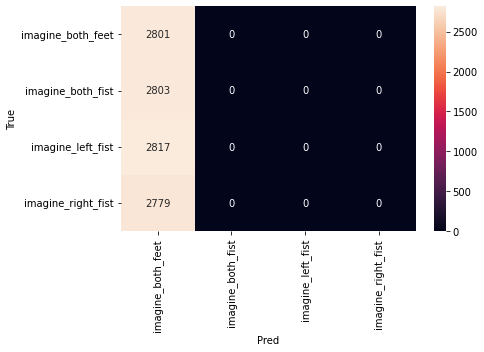

In [ ]:
import seaborn as sns
import pandas as pd
import io

figure = plt.figure(figsize=(7, 5))
cm_df = pd.DataFrame(cm, columns=class_names, index=class_names)
sns.heatmap(cm_df, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Pred')
plt.tight_layout()
plt.savefig('runs/gnn/cm.png')
plt.show()

In [ ]:
print('Number of trainable parameters')
sum(p.numel() for p in model.parameters() if p.requires_grad)

Number of trainable parameters


2176389

In [ ]:
[p.numel() for p in model.parameters() if p.requires_grad]

[2097152, 12800, 128, 32768, 256, 32768, 128, 128, 1, 256, 4]